In [1]:
import torch

In [3]:
x = torch.rand(5, 3)
print(x)

tensor([[0.5206, 0.0585, 0.5832],
        [0.7083, 0.4373, 0.0340],
        [0.4514, 0.8774, 0.7132],
        [0.4876, 0.0133, 0.4496],
        [0.4630, 0.3291, 0.5260]])


In [9]:
import urllib.request
from PIL import Image
from matplotlib import pyplot as plt

In [11]:
url = 'https://png.pngtree.com/thumb_back/fh260/background/20230610/pngtree-fat-orange-cat-sits-on-top-of-a-rock-image_2911772.jpg'
filename = 'fatcat.jpg'

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
request = urllib.request.Request(url, headers=headers)

with urllib.request.urlopen(request) as response:
    with open(filename, 'wb') as f:
        f.write(response.read())

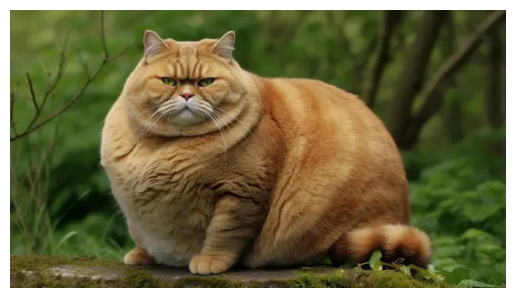

In [13]:
img = Image.open(filename)
plt.imshow(img)
plt.axis('off')
plt.show()

In [31]:
from torchvision import models, transforms
import requests 

In [33]:
model = models.resnet18(pretrained=True)
model.eval()

/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [41]:
def preprocess_image(image_path):
    input_image = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(), # converting the image to a tensor format required by pytorch 
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # color values
    ]) # the standard dimensions for ResNet images
    
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # the batch dimensions are needed for the model input
    return input_batch 

In [43]:
def predict_image_class(image_path):
    input_batch = preprocess_image(image_path)

    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')
    
    with torch.no_grad():
        output = model(input_batch)
    
    probabilities = torch.nn.functional.softmax(output[0], dim=0) # the softmax function is used to convert the raw logits into probability number between 0 and 1
    
    LABELS_URL = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
    labels = requests.get(LABELS_URL).text.splitlines() # the class labels are downloaded from the url
    
    _, predicted_idx = torch.max(probabilities, 0) # finds the class with the highest probability 
    return labels[predicted_idx], probabilities[predicted_idx].item()

In [45]:
image_path = "fatcat.jpg"  
predicted_class, confidence = predict_image_class(image_path)
print(f"Predicted class: {predicted_class} with confidence {confidence:.4f}")

Predicted class: tiger cat with confidence 0.3811
